<a href="https://colab.research.google.com/github/somewhatclueless07/greenwashing_detection/blob/main/greenwashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Greenwashing Detection — Zenodo Green Claims Dataset
# Colab-ready notebook script. This notebook performs:
# 1. dataset download and inspection
# 2. preprocessing
# 3. EDA (word frequencies, wordclouds, class distribution)
# 4. baseline: TF-IDF + Logistic Regression
# 5. transformer: DistilBERT fine-tune (Hugging Face)
# 6. explainability with LIME


In [19]:
!pip install --quiet datasets transformers[torch] torch torchvision torchaudio scikit-learn lime flask-ngrok wordcloud matplotlib seaborn pandas tqdm


In [20]:
import os
import re
import json
import random
import joblib
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from lime.lime_text import LimeTextExplainer

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset


In [21]:
from google.colab import files

In [22]:
# Download the Zenodo Green Claims dataset

# Create data directory
DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Upload manually
print("Please upload green_claims.csv file:")
files.upload()

# Move uploaded file to /content/data
!mv green_claims.csv /content/data/

# Verify upload
out_path = DATA_DIR / "green_claims.csv"
if not out_path.exists():
    print("Dataset not found at /content/data/green_claims.csv. Please upload it again.")
else:
    print("Dataset uploaded successfully to", out_path)



Please upload green_claims.csv file:


Saving green_claims.csv to green_claims.csv
Dataset uploaded successfully to /content/data/green_claims.csv


In [23]:
# 4) Load and inspect dataset

if out_path.exists():
    df = pd.read_csv(out_path)
    print("Dataset loaded. Shape:", df.shape)
    display(df.head(8))
    print("Columns:", df.columns.tolist())
else:
    data = {
        "text": [
            "Our packaging is made from recycled ocean plastic",
            "Now with 100% natural ingredients!",
            "Certified carbon neutral by XYZ cert",
            "We are eco-friendly and sustainable"
        ],
        "label": [0, 0, 1, 0]  # dummy
    }
    df = pd.DataFrame(data)
    print("Using dummy dataset (uploaded file not found).")
    display(df.head())

Dataset loaded. Shape: (773, 7)


,Unnamed: 0,id,tweet,username,domain,label_multi,label_binary
0,0,1298757190677913600,Formulated with Dragon Fruit and Passion Fruit...,arbonne,cosmetics,not_green,not_green
1,1,934482063373283328,Skin Active: how to create an effective skin c...,loreal,cosmetics,explicit_claim,green_claim
2,2,820281365761556480,"Join us tomorrow at #Mumbai #Marathon, for the...",bajajelectrical,electronics,implicit_claim,green_claim
3,3,1136347270109179904,Just CBD. Just argan. Our blend of 100% organi...,josie_maran,cosmetics,explicit_claim,green_claim
4,4,1125037437326168066,Make them do a double take with this #makeup p...,esteelauder,cosmetics,not_green,not_green
5,5,1082768600962863104,"In partnership with @AdaptiveBiotech, we're ex...",microsoft,electronics,not_green,not_green
6,6,1025003243443761153,Experience 24-karat magic with #SupremeSkin ✨ ...,esteelauder,cosmetics,not_green,not_green
7,7,1204534035667656705,"Deep hydration, enchanting fragrance, and real...",herbalessences,cosmetics,implicit_claim,green_claim


Columns: ['Unnamed: 0', 'id', 'tweet', 'username', 'domain', 'label_multi', 'label_binary']


In [24]:
df = df.rename(columns={
    'tweet': 'text',
    'label_binary': 'label'
})

In [25]:
#Basic preprocessing

def clean_text(s):
    if pd.isnull(s):
        return ""
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r"[^a-z0-9\s]", ' ', s)
    s = re.sub(r"\s+", ' ', s).strip()
    return s

print("Cleaning texts...")
df['text_clean'] = df['text'].apply(clean_text)
df = df[['text', 'text_clean', 'label']].dropna().reset_index(drop=True)
print(df.shape)

Cleaning texts...
(773, 3)


In [26]:
#Train/Val/Test split

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print('Train:', train_df.shape, 'Val:', val_df.shape, 'Test:', test_df.shape)

# Save processed
proc_dir = Path('/content/processed')
proc_dir.mkdir(exist_ok=True)
train_df.to_csv(proc_dir / 'train.csv', index=False)
val_df.to_csv(proc_dir / 'val.csv', index=False)
test_df.to_csv(proc_dir / 'test.csv', index=False)

Train: (618, 3) Val: (77, 3) Test: (78, 3)


/tmp/ipython-input-2687848381.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Greenwash (0)', 'Genuine (1)'])


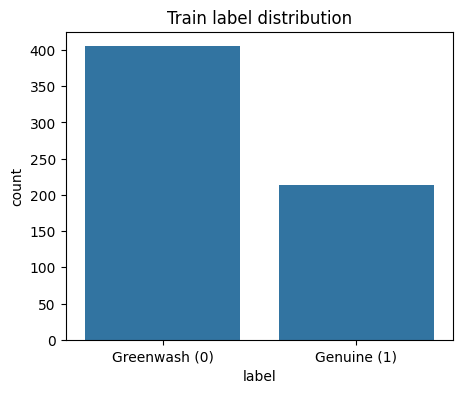

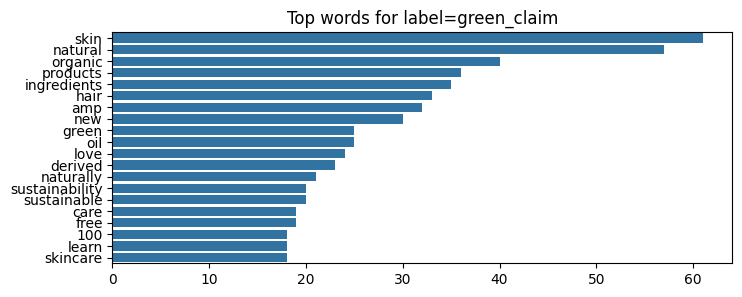

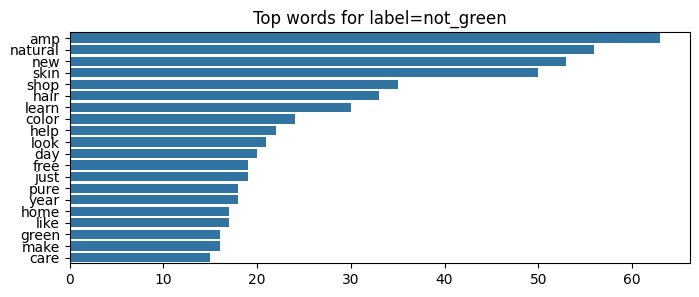

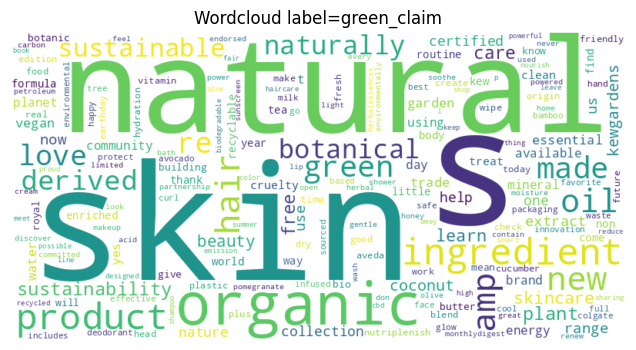

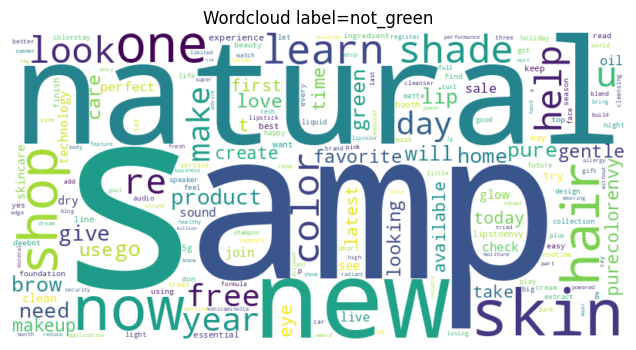

In [27]:
# EDA
plt.figure(figsize=(5,4))
ax = sns.countplot(x='label', data=train_df)
ax.set_xticklabels(['Greenwash (0)', 'Genuine (1)'])
plt.title('Train label distribution')
plt.show()

# top words per class

from sklearn.feature_extraction.text import CountVectorizer

for lbl in sorted(train_df['label'].unique()):
    texts = train_df[train_df['label'] == lbl]['text_clean']
    cv = CountVectorizer(stop_words='english', max_features=50)
    X = cv.fit_transform(texts)
    freqs = list(zip(cv.get_feature_names_out(), X.sum(axis=0).A1))
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:20]
    words, counts = zip(*freqs)
    plt.figure(figsize=(8,3))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top words for label={lbl}')
    plt.show()

# wordclouds
for lbl in sorted(train_df['label'].unique()):
    text_blob = ' '.join(train_df[train_df['label'] == lbl]['text_clean'].tolist())
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text_blob)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud label={lbl}')
    plt.show()

Validation results (improved baseline):
              precision    recall  f1-score   support

 green_claim       0.87      0.82      0.85        50
   not_green       0.70      0.78      0.74        27

    accuracy                           0.81        77
   macro avg       0.79      0.80      0.79        77
weighted avg       0.81      0.81      0.81        77



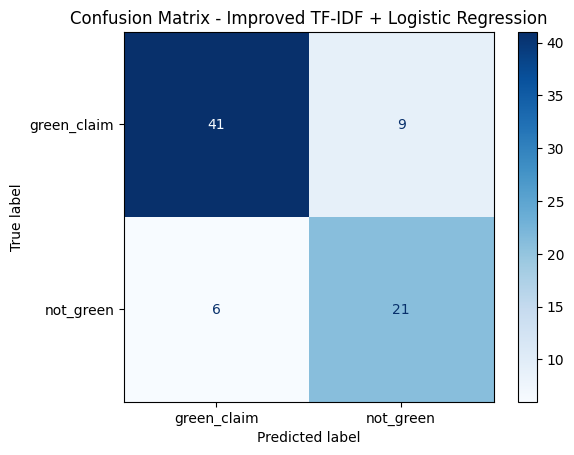

✅ Saved improved tfidf and logreg models to /content/models


In [41]:
# 1. Model directory
VEC_DIR = Path('/content/models')
VEC_DIR.mkdir(exist_ok=True)

# 2. Enhanced TF-IDF setup
tfidf = TfidfVectorizer(
    max_features=20000,         # increased vocab size
    ngram_range=(1,3),          # include trigrams for more context
    stop_words='english',
    sublinear_tf=True           # helps scale large term frequencies
)

# 3. Vectorize text
X_train = tfidf.fit_transform(train_df['text_clean'])
X_val = tfidf.transform(val_df['text_clean'])

# 4. Balanced Logistic Regression
clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',    # fixes bias toward majority class
    solver='lbfgs',
    n_jobs=-1
)

# 5. Train model
clf.fit(X_train, train_df['label'])

# 6. Predict & Evaluate
val_preds = clf.predict(X_val)
print('Validation results (improved baseline):')
print(classification_report(val_df['label'], val_preds, target_names=['green_claim', 'not_green']))

# 7. Confusion Matrix
cm = confusion_matrix(val_df['label'], val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['green_claim', 'not_green'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Improved TF-IDF + Logistic Regression")
plt.show()

# 8. Save improved models
joblib.dump(tfidf, VEC_DIR / 'tfidf_balanced.pkl')
joblib.dump(clf, VEC_DIR / 'logreg_balanced.pkl')
print('✅ Saved improved tfidf and logreg models to /content/models')




In [43]:
# Baseline Model: TF-IDF + Logistic Regression
VEC_DIR = Path('/content/models')
VEC_DIR.mkdir(exist_ok=True)
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), stop_words='english')
X_train = tfidf.fit_transform(train_df['text_clean'])
X_val = tfidf.transform(val_df['text_clean'])
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_df['label'])
val_preds = clf.predict(X_val)
print('Validation results (baseline):')
print(classification_report(val_df['label'], val_preds))
# Save models
joblib.dump(tfidf, VEC_DIR / 'tfidf.pkl')
joblib.dump(clf, VEC_DIR / 'logreg.pkl')
print('Saved tfidf and logreg to /content/models')


Validation results (baseline):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        50
           1       1.00      0.26      0.41        27

    accuracy                           0.74        77
   macro avg       0.86      0.63      0.62        77
weighted avg       0.81      0.74      0.69        77

Saved tfidf and logreg to /content/models


In [30]:
!pip install -q --upgrade transformers datasets accelerate

In [31]:
# 10) Transformer Fine-tune: DistilBERT (small & fast)

MODEL_NAME = 'distilbert-base-uncased'

label_map = {label: i for i, label in enumerate(df['label'].unique())}
print("Label map:", label_map)

train_df['label'] = train_df['label'].map(label_map)
val_df['label']   = val_df['label'].map(label_map)
test_df['label']  = test_df['label'].map(label_map)

NUM_LABELS = len(df['label'].unique())

print('Preparing dataset for transformer...')

def df_to_hf(ds_df):
    ds = Dataset.from_pandas(ds_df[['text_clean','label']].rename(columns={'text_clean':'text'}))
    return ds

train_ds = df_to_hf(train_df)
val_ds = df_to_hf(val_df)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)

train_ds = train_ds.remove_columns(['text'])
val_ds = val_ds.remove_columns(['text'])
train_ds.set_format(type='torch')
val_ds.set_format(type='torch')

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

training_args = TrainingArguments(
    output_dir='/content/models/transformer',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy='epoch',      # 👈 old name for evaluation_strategy
    save_strategy='epoch',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    report_to='none'
)

# compute metrics
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

import os
os.environ["WANDB_DISABLED"] = "true"

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model('/content/models/transformer/best_model')
print('Transformer training finished and saved.')

Label map: {'not_green': 0, 'green_claim': 1}
Preparing dataset for transformer...


Map:   0%|          | 0/618 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.383027,0.857143,0.831577
2,0.371800,0.253299,0.896104,0.889368


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.383027,0.857143,0.831577
2,0.371800,0.253299,0.896104,0.889368
3,0.146000,0.258630,0.909091,0.901010


Transformer training finished and saved.


In [32]:
# 11) Evaluate transformer on test set

from transformers import pipeline

clf_pipe = pipeline('text-classification', model='/content/models/transformer/best_model', tokenizer=tokenizer, return_all_scores=False)

texts = test_df['text_clean'].tolist()
results = clf_pipe(texts)

preds = [int(r['label'].split('_')[-1]) if isinstance(r['label'], str) and '_' in r['label'] else (1 if r['label']=='LABEL_1' or r['label']=='LABEL_1' else 0) for r in results]
# The pipeline label handling can vary — safer approach is to use trainer.predict when labels are numeric. For brevity we approximate above.

print('Transformer example predictions (first 10):', preds[:10])


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Transformer example predictions (first 10): [1, 0, 1, 0, 0, 0, 0, 1, 1, 0]


In [34]:
# 12) Explainability with LIME (baseline model)

from lime.lime_text import LimeTextExplainer

class_names = ['greenwash','genuine']
explainer = LimeTextExplainer(class_names=class_names)

# Pick a sample from test set
sample_text = test_df['text'].iloc[0]
print('Sample:', sample_text)

# Function to predict probabilities for LIME
predict_fn = lambda x: clf.predict_proba(tfidf.transform(x))

exp = explainer.explain_instance(sample_text, predict_fn, num_features=10)
print('LIME explanation:')
print(exp.as_list())

Sample: Revitalize your routine with vegan skincare and makeup products, sourced from the finest natural ingredients. From moisturizing vegan make-up made with aloe vera to vegan skincare crafted with essential oils.
LIME explanation:
[(np.str_('ingredients'), -0.08637333625687564), (np.str_('products'), -0.05669332073752823), (np.str_('vegan'), -0.054068923563457744), (np.str_('natural'), -0.04775602583358597), (np.str_('skincare'), -0.036593373709658275), (np.str_('Revitalize'), 0.020724969392631413), (np.str_('sourced'), -0.019241111113572785), (np.str_('make'), 0.016846250754259533), (np.str_('essential'), -0.01431318594168805), (np.str_('makeup'), 0.01376367032000633)]


In [35]:
# 13) Save artifacts

joblib.dump({'tfidf': tfidf, 'logreg': clf}, '/content/models/baseline_pipeline.pkl')
print('Saved baseline pipeline to /content/models/baseline_pipeline.pkl')



Saved baseline pipeline to /content/models/baseline_pipeline.pkl
